In [55]:
# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from datetime import datetime as dt

# magic command to display matplotlib plots inline within the ipython notebook
%matplotlib inline
import json

In [56]:
import xml.etree.ElementTree as ET
from collections import namedtuple

import requests

MUNI_METRO_ROUTES = frozenset(["N", "M", "L", "KT", "J"])
Vehicle = namedtuple("Vehicle", "lat lon route_tag")

def parse_muni_data(api_response):

    vehicles = ET.fromstring(api_response).getchildren()
    vehicles = [
        v for v in vehicles
        if v.attrib.get('routeTag') in MUNI_METRO_ROUTES
    ]
    filtered_vehicles = [
        Vehicle(v.attrib['lat'], v.attrib['lon'], v.attrib['routeTag'])
        for v in vehicles
        if 'lat' in v.attrib and 'lon' in v.attrib
    ]
    return filtered_vehicles

def get_raw_muni_data():
    return requests.get("http://webservices.nextbus.com/service/publicXMLFeed?command=vehicleLocations&a=sf-muni&t=0").text

locs = parse_muni_data(get_raw_muni_data())
with open("testdata.json", 'w') as f:
    f.write(json.dumps((list(map(lambda x: dict(x._asdict()), locs)))))

In [57]:
df_gps = pd.read_json('testdata.json')
print('There are {:,} rows'.format(len(df_gps)))


There are 73 rows


In [58]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

def dbscan_reduce(df, epsilon, x='lon', y='lat'):
    start_time = time.time()
    # represent points consistently as (lat, lon) and convert to radians to fit using haversine metric
    coords = df.as_matrix(columns=[y, x])    
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    print('Number of clusters: {:,}'.format(num_clusters))
    
    clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])
    
    # find the point in each cluster that is closest to its centroid
    centermost_points = clusters.map(get_centermost_point)

    # unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
    lats, lons = zip(*centermost_points)
    rep_points = pd.DataFrame({x:lons, y:lats})
    rep_points.tail()
    
    # pull row from original data set where lat/lon match the lat/lon of each row of representative points
    rs = rep_points.apply(lambda row: df[(df[y]==row[y]) & (df[x]==row[x])].iloc[0], axis=1)
    
    # all done, print outcome
    message = 'Clustered {:,} points down to {:,} points, for {:.2f}% compression in {:,.2f} seconds.'
    print(message.format(len(df), len(rs), 100*(1 - float(len(rs)) / len(df)), time.time()-start_time))    
    return rs


Number of clusters: 8
Clustered 73 points down to 8 points, for 89.04% compression in 0.11 seconds.


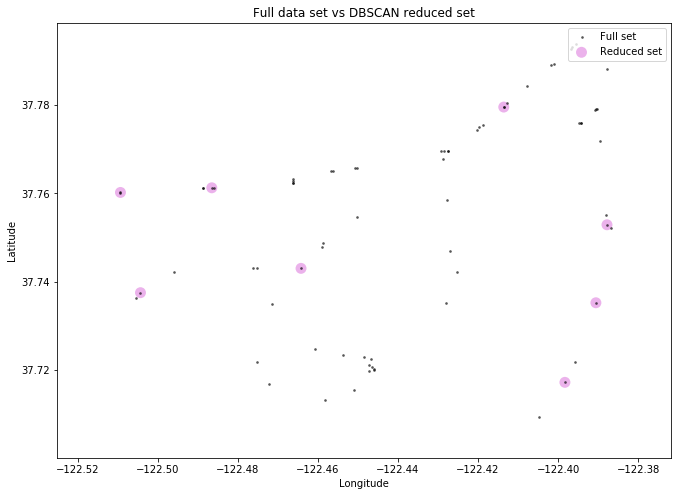

In [71]:
eps_rad = 1.5 / kms_per_radian
df_clustered = dbscan_reduce(df_gps, epsilon=eps_rad)
# show a map of the worldwide data points
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(df_clustered['lon'], df_clustered['lat'], c='m', edgecolor='None', alpha=0.3, s=120)
df_scatter = ax.scatter(df_gps['lon'], df_gps['lat'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')


In [54]:
df_clustered

,lat,lon,route_tag
0,37.76945,-122.42950,N
1,37.72262,-122.44676,N
